In [1]:
import scanpy as sc
import pandas as pd
import statistics
import sys
import getopt
import os
import matplotlib.pyplot as mp
import anndata as ad
import time

In [2]:
sc.settings.figdir = "../results/figures/"
print(sc.__version__)

1.10.1


In [10]:
#adata.write_h5ad("ASAP_adata_umap_nointegration.h5")
adata = ad.read_h5ad("h5s/ASAP_adata_umap_integration.h5")

In [4]:
microglia = adata[adata.obs.leiden.isin(["4"])]

2025-03-18 16:46:38,553 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-18 16:46:42,164 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-18 16:46:42,240 - harmonypy - INFO - Iteration 1 of 10
2025-03-18 16:46:49,434 - harmonypy - INFO - Iteration 2 of 10
2025-03-18 16:46:57,610 - harmonypy - INFO - Iteration 3 of 10
2025-03-18 16:47:01,607 - harmonypy - INFO - Iteration 4 of 10
2025-03-18 16:47:04,881 - harmonypy - INFO - Converged after 4 iterations
/usr/local/lib/python3.10/dist-packages/scanpy/external/pp/_harmony_integrate.py:97: ImplicitModificationWarning: Setting element `.obsm['X_pca_harmony']` of view, initializing view as actual.
  adata.obsm[adjusted_basis] = harmony_out.Z_corr.T


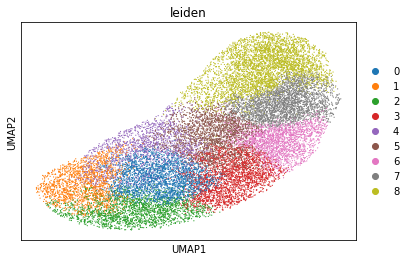

In [5]:
sc.external.pp.harmony_integrate(adata = microglia, key = ["batch", "patient", "sex"])
sc.pp.neighbors(microglia, n_neighbors = 15, n_pcs = 20, use_rep = 'X_pca_harmony')
sc.tl.leiden(microglia, resolution = 0.5, random_state = 0, n_iterations = -1, directed = False, flavor = "igraph")
sc.tl.paga(microglia)
sc.pl.paga(microglia, plot = False)
sc.tl.umap(microglia, init_pos = "paga")
sc.pl.umap(microglia, color = 'leiden')

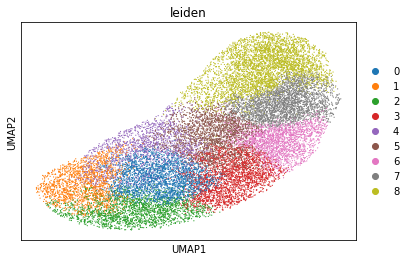

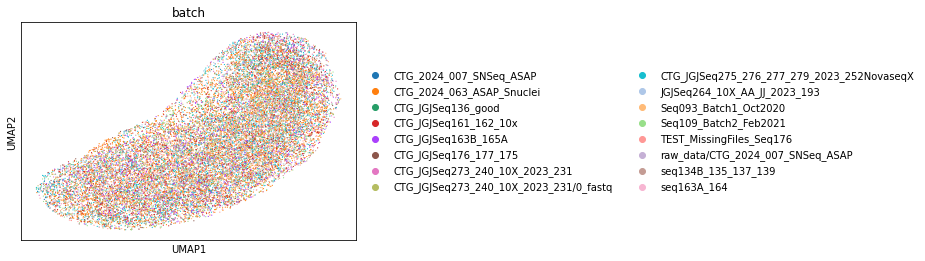

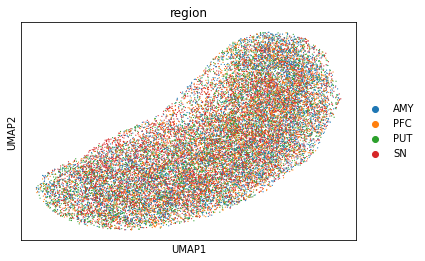

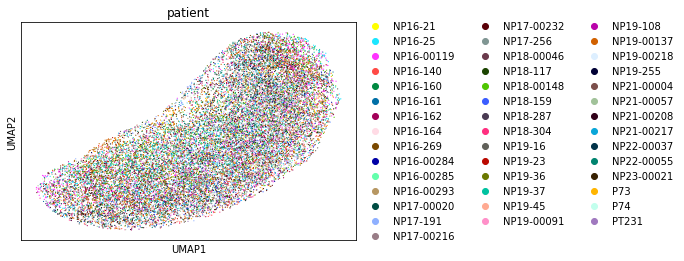

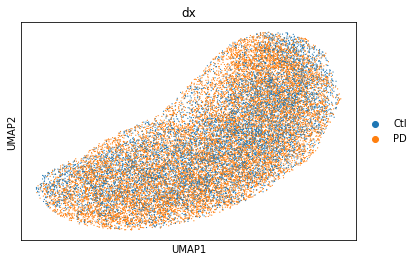

In [9]:
sc.pl.umap(microglia, color = 'leiden', save = "_microglia.pdf")

#sc.pl.pca_variance_ratio(microglia, log=True)
sc.pl.umap(microglia, color = 'batch', save = "_microglia_integration_batch_patient_batch.pdf")
sc.pl.umap(microglia, color = 'region', save = "_microglia_integration_batch_patient_region.pdf")
sc.pl.umap(microglia, color = 'patient', save = "_microglia_integration_batch_patient_patient.pdf")
sc.pl.umap(microglia, color = 'dx', save = "_microglia_integration_batch_patient_dx.pdf")
microglia.write_h5ad("./h5s/ASAP_microglia_adata_umap_integration.h5")

In [8]:
microglia_list = {"SN" :  microglia[microglia.obs["region"].isin(["SN"])], "PUT" : microglia[microglia.obs["region"].isin(["PUT"])], "PFC" : microglia[microglia.obs["region"].isin(["PFC"])], "AMY" : microglia[microglia.obs["region"].isin(["AMY"])]}
import re
for region in ["SN", "PUT", "AMY", "PFC"]:
    for cluster in microglia_list[region].obs.leiden.unique().tolist():
            for sample in microglia_list[region].obs.sample_name.unique().tolist():
                dir_name = os.path.join("../barcodes_microglia/", region)
                if not os.path.exists(dir_name):
                    os.makedirs(dir_name)
                file_name = os.path.join(dir_name, sample + "_merged.clusters_" + cluster + ".tsv")
                barcodes = microglia_list[region][microglia_list[region].obs["region"].isin([region]) & microglia_list[region].obs["leiden"].isin([cluster]) & microglia_list[region].obs["sample_name"].isin([sample])].obs_names.tolist()
                barcodes_dups = [i[:-2] for i in barcodes if bool(re.search(r'\-\d+\-\d+$', i))]
                barcodes_nodups = [i for i in barcodes if not bool(re.search(r'\-\d+\-\d+$', i))]
                barcodes = barcodes_dups + barcodes_nodups
                if len(barcodes) > 0:
                    with open(file_name, "w") as fout:
                        for cell in barcodes:
                            fout.write("%s\n" % cell)

In [3]:
tlrs = [i for i in microglia.var_names.tolist() if i.startswith("TLR")]
parps = [i for i in microglia.var_names.tolist() if i.startswith("PARP")]
hlas = [i for i in microglia.var_names.tolist() if i.startswith("HLA")]
upreg_sn_pseudobulk = pd.read_csv("/scale/gr01/shared/jjakobsson/processed/ASAP_snRNA_spatial_invitro/data/tables/upreg_sn_genes_pseudobulk.tab", header=None)

upreg_sn_pseudobulk = upreg_sn_pseudobulk[0].tolist()
genes_to_check = ["FKBP5", "CTBP2", "APOE", "SPP1", "B2M", "AIF1", "CD68", "CD206", "CD45", "IFNAR1", "LRRK2"] + tlrs + parps + hlas + upreg_sn_pseudobulk

genes_to_check

genes_to_check = [i for i in genes_to_check if i in microglia.var_names.tolist()]

In [5]:
sc.get.obs_df(microglia, genes_to_check).to_csv("../results/tables/microglia_subcluster_genes_counts.csv")
cell_meta=microglia.obs.copy()
cell_meta['Barcode'] = cell_meta.index
cell_meta['UMAP1'] = microglia.obsm['X_umap'][:,0]
cell_meta['UMAP2'] = microglia.obsm['X_umap'][:,1]
gene_meta=adata.var.copy()
gene_meta['GeneName']=gene_meta.index
cell_meta.to_csv('../results/tables/counts_microglia_cellMeta_integrated_umap.csv',index=None)
gene_meta.to_csv('../results/tables/counts_microglia_geneMeta_integrated_umap.csv',index=None)


In [2]:
microglia = ad.read_h5ad("h5s/ASAP_microglia_adata_umap_integration.h5")

<Axes: xlabel='leiden', ylabel='LRRK2'>

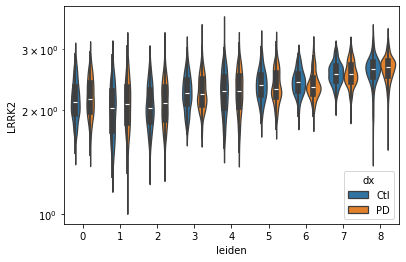

In [21]:
df = sc.get.obs_df(microglia, ["LRRK2", "leiden", "dx"])
# sc.pl.violin(microglia, keys = "LRRK2", groupby="leiden", inner="box", stripplot=False)
import seaborn as sns
sns.violinplot(data=df, x="leiden", y="LRRK2", hue="dx", inner="box", log_scale=True)


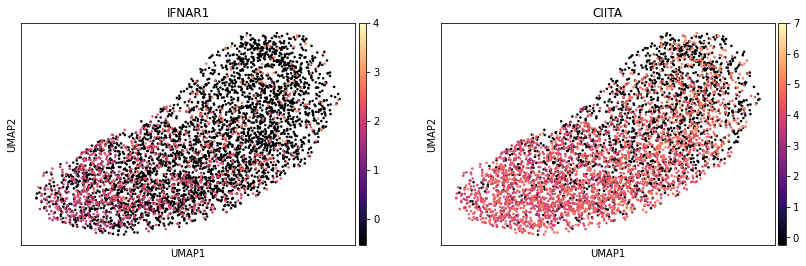

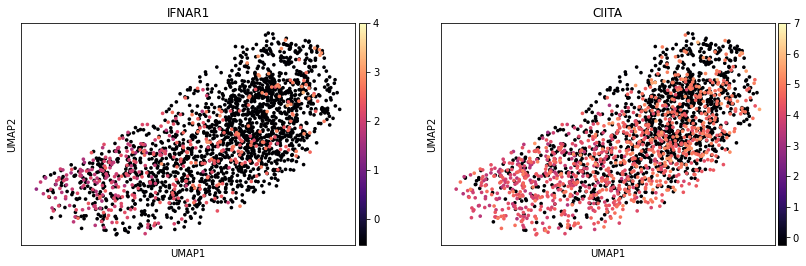

In [18]:
microglia_SN_PD = microglia[(microglia.obs["region"].isin(["SN"])) & (microglia.obs["dx"].isin(["PD"]))]
microglia_SN_ctl = microglia[(microglia.obs["region"].isin(["SN"])) & (microglia.obs["dx"].isin(["Ctl"]))]
sc.pl.umap(microglia_SN_PD, color=["IFNAR1", "CIITA"], vmax = [4,7], color_map="magma")
sc.pl.umap(microglia_SN_ctl, color=["IFNAR1", "CIITA"], vmax = [4,7], color_map="magma")
